<h1>Efficient long-range entanglement</h1>
Using dynamic circuits, python and qiskit

In [1]:
# import image module
from IPython.display import Image

# get the image
Image(url="https://miro.medium.com/v2/resize:fit:1248/1*l6kyAkjsimtlxmvPMAZ9eQ.png", width=700, height=300)

<h2>Problem:</h2>
CNOT is a very important gate in quantum computing that is used a lot in quantum algorithms. For example the number of CNOT gates in QFT scales as O(n<sup>2</sup>) with n being the number of qubits. Also, each swap gate is made of 3 CNOT gates.

In the future we will have quantum computers with 1000's of qubits, but if we wanted to perform CNOT between qubit 1 and qubit 500. It will be very hard!!

Dynamic circuits can help us reduce the circuit depth and rate error. In this case using dynamic circuits for long-range CNOT gave in some cases more than 40% reduction in error!!

<h2>Outline</h2>
<ol>
<li>Installing required packages:</li>
<li>Functions for unitary and dynamic circuits:</li>
<li>Functions for error and running the circuits:</li>
<li>Example 1: Comparing dynamic and unitary when control is 1</li>
<li>Example 2: Comparing dynamic and unitary when control is 0</li>
</ol>

<h2>Installing required packages:</h2>

In [2]:
!pip install qiskit['all']

In [3]:
!pip install qiskit-aer

<h2>Functions for implementing unitary and dynamic circuits:</h2>

In [4]:
import qiskit
from qiskit import *

In [5]:
# A function that returns a unitary circuit with 1 CNOT
# control: 0
# target: n-1
def unitary_CNOT(n, x):

  qc = QuantumCircuit(n, n)

  # adds an x_gate before the control if x is 1
  if x==1:
    qc.x(0)
  qc.barrier()

  middle = int((n-2)/2)

  for j in range(middle):
    qc.cx(j, j+1)
    qc.cx(j+1, j)

  for j in range(1, middle+1):
    qc.cx(n-j, n-j-1)
    qc.cx(n-j-1, n-j)

  qc.cx(middle, middle+1)

  for j in range(middle+1, n-1):
    qc.cx(j, j+1)
    qc.cx(j+1, j)

  for j in range(middle+3, n+1):
    qc.cx(n-j+1, n-j)
    qc.cx(n-j, n-j+1)

  qc.barrier()
  qc.measure([0, n-1], [0, n-1])

  return qc

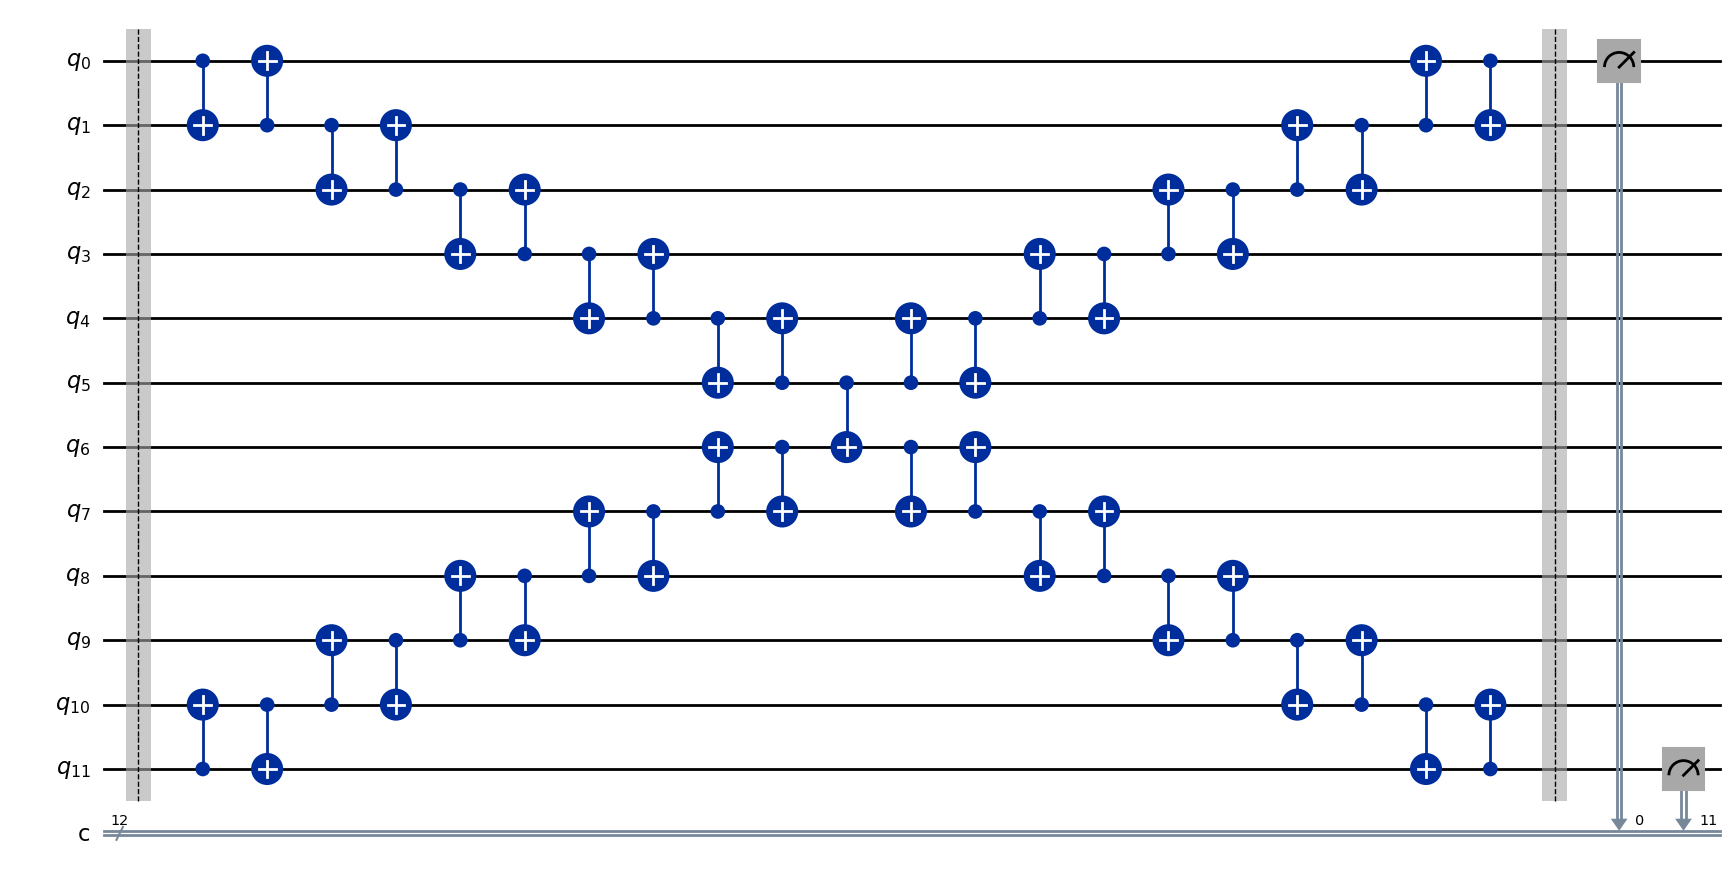

In [6]:
# note that the input n should be even for this function
qc_u = unitary_CNOT(12, 0)
qc_u.draw('mpl')

In [7]:
# A function that returns a dynamic circuit with 1 CNOT
# control: 0
# target: n-1
def dynamic_CNOT(n, x):

  qc = QuantumCircuit(n, n)

  qreg = QuantumRegister(n)
  creg = ClassicalRegister(n)
  qc = QuantumCircuit(qreg, creg)

  meas1 = []
  meas2 = []

  if x==1:
    qc.x(0)

  for i in range(2, n-1, 2):
    qc.h(i)
    meas1.append(i)
  qc.barrier()

  for i in range(0, n-2, 2):
    qc.cx(i, i+1)
  for i in range(1, n-1, 2):
    qc.cx(i, i+1)
  qc.barrier()

  for i in range(1, n, 2):
    qc.h(i)
    meas2.append(i)

  qc.measure(meas1, meas1)
  qc.barrier()
  qc.measure(meas2, meas2)


  for i in meas1:
    with qc.if_test((creg[i], 1)):
      qc.x(n-1)

  for i in meas2:
    with qc.if_test((creg[i], 1)):
      qc.z(0)
  qc.barrier()
  qc.measure([0, n-1], [0, n-1])

  return qc

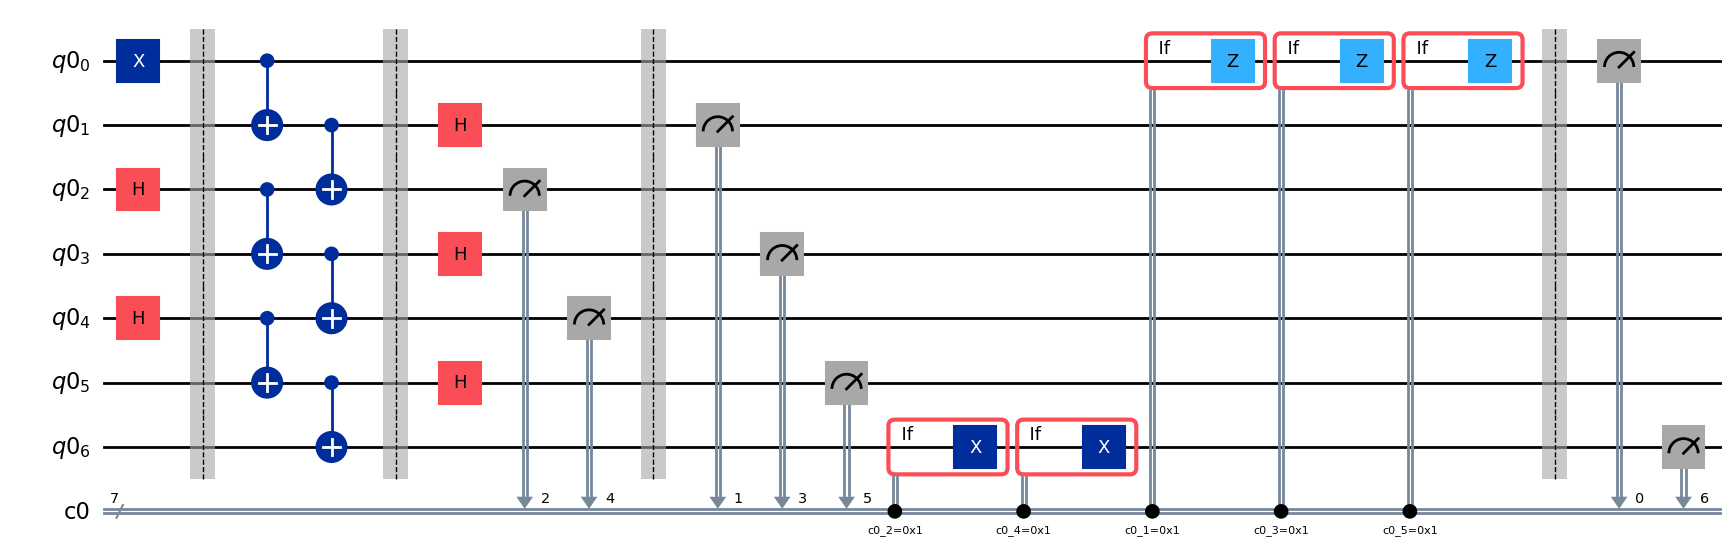

In [8]:
# note that the input n of this function should be odd
qc_d = dynamic_CNOT(7, 1)
qc_d.draw('mpl')

<h2>Functions for error and running the circuits:</h2>

In [9]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [10]:
def noise():
    # Example error probabilities
    p_reset = 0.00005
    p_meas = 0.00005
    p_gate1 = 0.000008

    # QuantumError objects
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate1_cx = pauli_error([('X',p_gate1*10000), ('I', 1 - p_gate1*10000)])
    error_gate2 = error_gate1.tensor(error_gate1_cx)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

In [11]:
# Function that calculates the result but without error using local simulator
def resultsNoError(qc, n, shots):
  simulator = AerSimulator()
  circ = transpile(qc, simulator, optimization_level = 0)

  # Run and get counts
  result = simulator.run(circ, shots=shots).result()
  counts = result.get_counts(circ)

  x = {}

  # In our result if for example we have 8 qubits we will get a string of 8 bits
  # We are interested only in the control(qubit 0) and target qubit(n-1)
  # The following line of code extracts these 2 bits from the string
  # So now our string becomes of length 2
  for res in counts:
    key = res[0]+res[n-1]
    if key not in x:
      x[key] = counts[res]
    else:
      x[key] = x[key] + counts[res]

  return counts, x

In [12]:
all_d = []
for i in range(5, 18, 2):
  qc_d = dynamic_CNOT(i, 1)
  x, y = resultsNoError(qc_d, i, 1000)
  all_d.append(y)

In [13]:
all_d

[{'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000}]

In [14]:
all_u = []
for i in range(6, 18, 2):
  qc_d = unitary_CNOT(i, 1)
  x, y = resultsNoError(qc_d, i, 1000)
  all_u.append(y)

In [15]:
all_u

[{'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000},
 {'11': 1000}]

In [16]:
# Function that calculates the result with error noise added to the local simulator
def resultsWithError(qc, n, shots):
  # This function is the same as above with 1 modification: noise_model = noise()
  simulator = AerSimulator(noise_model = noise())
  circ = transpile(qc, simulator, optimization_level = 0)

  # Run and get counts
  result = simulator.run(circ, shots=shots).result()
  counts = result.get_counts(circ)

  x = {}

  for res in counts:
    key = res[0]+res[n-1]
    if key not in x:
      x[key] = counts[res]
    else:
      x[key] = x[key] + counts[res]

  return counts, x

<h2>Example 1: Comparing dynamic and unitary when control is 1</h2>

In [17]:
import time

In [18]:
st = time.time()
all_d = []
for i in range(5, 18, 2):
  qc_d = dynamic_CNOT(i, 1)
  x, y = resultsWithError(qc_d, i, 10000)
  all_d.append((i, str(100*y['11']/10000)+'%'))
all_d
et = time.time()
print("minutes: ", (et-st)/60)

minutes:  16.959301114082336


In [19]:
print(all_d)

[(5, '85.19%'), (7, '78.64%'), (9, '72.99%'), (11, '68.7%'), (13, '65.38%'), (15, '61.27%'), (17, '59.29%')]


In [20]:
st = time.time()
all_u = []
for i in range(6, 17, 2):
  qc_d = unitary_CNOT(i, 1)
  x, y = resultsWithError(qc_d, i, 10000)
  all_u.append((i, str(100*y['11']/10000)+'%'))
all_u
et = time.time()
print("minutes: ", (et-st)/60)

minutes:  4.891448851426443


In [21]:
print(all_u)

[(6, '42.3%'), (8, '33.55%'), (10, '30.05%'), (12, '28.06%'), (14, '26.0%'), (16, '25.43%')]


In [22]:
all_d_plot = [f[1] for f in all_d]
all_u_plot = [f[1] for f in all_u]

print(all_d_plot)
print(all_u_plot)

['85.19%', '78.64%', '72.99%', '68.7%', '65.38%', '61.27%', '59.29%']
['42.3%', '33.55%', '30.05%', '28.06%', '26.0%', '25.43%']


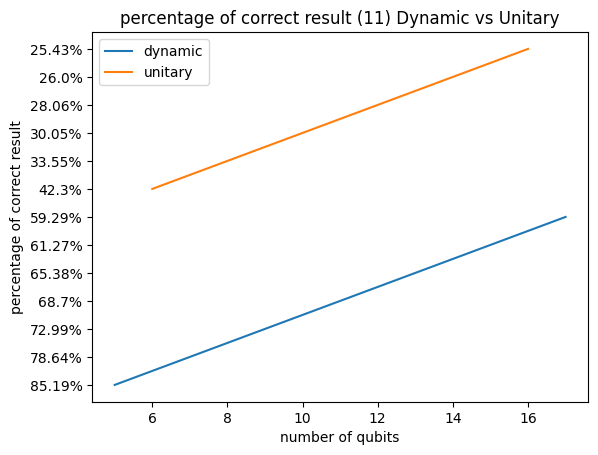

In [23]:
import matplotlib.pyplot as plt
plt.plot(list(range(5, 18, 2)), all_d_plot)
plt.plot(list(range(6, 17, 2)), all_u_plot)
plt.legend(['dynamic', 'unitary'])
plt.title("percentage of correct result (11) Dynamic vs Unitary")
plt.xlabel("number of qubits")
plt.ylabel("percentage of correct result")
plt.show()

<h2>Example 2: Comparing dynamic and unitary when control is 0</h2>

In [24]:
st = time.time()
all_d2 = []
for i in range(5, 18, 2):
  qc_d = dynamic_CNOT(i, 0)
  x, y = resultsWithError(qc_d, i, 10000)
  all_d2.append((i, str(100*y['00']/10000)+'%'))
all_d2
et = time.time()
print("minutes: ", (et-st)/60)

minutes:  16.926021659374236


In [25]:
all_d2

[(5, '85.04%'),
 (7, '78.52%'),
 (9, '72.81%'),
 (11, '68.92%'),
 (13, '65.22%'),
 (15, '61.74%'),
 (17, '59.51%')]

In [26]:
st = time.time()
all_u2 = []
for i in range(6, 17, 2):
  qc_d = unitary_CNOT(i, 0)
  x, y = resultsWithError(qc_d, i, 10000)
  all_u2.append((i, str(100*y['00']/10000)+'%'))
all_u2
et = time.time()
print("minutes: ", (et-st)/60)

minutes:  0.3300751248995463


In [27]:
all_u2

[(6, '42.48%'),
 (8, '33.71%'),
 (10, '30.03%'),
 (12, '26.95%'),
 (14, '26.08%'),
 (16, '26.06%')]

In [28]:
all_d_plot2 = [f[1] for f in all_d2]
all_u_plot2 = [f[1] for f in all_u2]

print(all_d_plot2)
print(all_u_plot2)

['85.04%', '78.52%', '72.81%', '68.92%', '65.22%', '61.74%', '59.51%']
['42.48%', '33.71%', '30.03%', '26.95%', '26.08%', '26.06%']


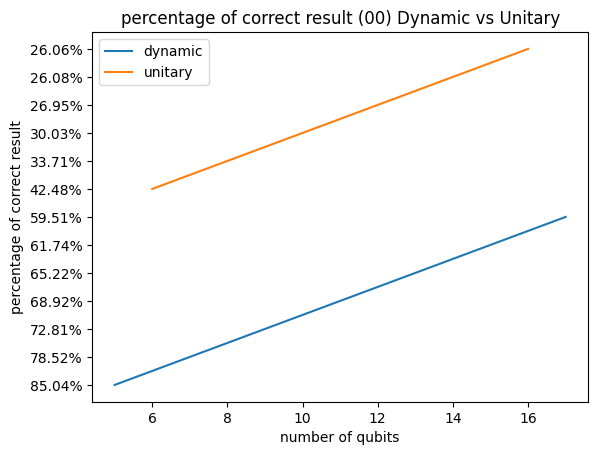

In [29]:
import matplotlib.pyplot as plt
plt.plot(list(range(5, 18, 2)), all_d_plot2)
plt.plot(list(range(6, 17, 2)), all_u_plot2)
plt.legend(['dynamic', 'unitary'])
plt.title("percentage of correct result (00) Dynamic vs Unitary")
plt.xlabel("number of qubits")
plt.ylabel("percentage of correct result")
plt.show()